# Requirements

In [102]:

# Scientific computing
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset

# Computer Vision and Image Processing
from PIL import Image
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings

warnings.filterwarnings('ignore')


# Config

The `config` object in this notebook is used to centralize and manage important parameters and settings for your model and data processing. By using a configuration class, you can easily change values like image size, batch size, class names, and device (CPU/GPU/MPS) in one place, making your code more organized and maintainable.

**In this notebook, `config` is used for:**
- Setting the image size for preprocessing and model input (`IMAGE_SIZE`)
- Defining the batch size for data loading (`BATCH_SIZE`)
- Listing the class names and number of classes (`CLASSES`, `NUM_CLASSES`)
- Selecting the computation device (`DEVICE`)

This approach helps ensure consistency and makes it easy to update parameters across your codebase.

In [92]:
# Configuration class for model and data parameters
class Config:
    IMAGE_SIZE = (224, 224)  # Image size for input to the model
    BATCH_SIZE = 32          # Batch size for DataLoader
    CLASSES = ['None', 'back', 'front']  # List of class names
    NUM_CLASSES = len(CLASSES)           # Number of classes
    # Set device to MPS if available (for Apple Silicon), otherwise CPU
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Instantiate the configuration
config = Config()

# Transformation 

During prediction, we apply the same transformations (`val_transforms`) to the input image as we did during validation/training. This ensures the image has the correct size, normalization, and format expected by the model.

If we skip these transforms, the model may receive data in an unexpected format, leading to poor or invalid predictions.

**Key reasons for applying transformations during prediction:**
- **Resize and crop:** Ensures the image matches the input size the model was trained on.
- **ToTensor:** Converts the image to a PyTorch tensor.
- **Normalize:** Scales pixel values to the same distribution as the training data (e.g., ImageNet mean/std).

> Transformations during prediction ensure the input image matches the format, size, and normalization expected by the model, leading to reliable and accurate predictions.

In [ ]:
# Define the validation transforms for preprocessing images before inference
val_transforms = transforms.Compose([
    transforms.Resize(config.IMAGE_SIZE),  # Resize image to the configured size
    transforms.CenterCrop(config.IMAGE_SIZE),  # Crop the center of the image
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Normalize with ImageNet mean
                         std=[0.229, 0.224, 0.225])   # and std
])


# Define the Model Architecture 

###  Why Define the Model Architecture During Prediction?

When using **PyTorch** for model inference (prediction), it is essential to define the **exact model architecture** in your code **before loading the trained weights (checkpoint)**. 

This is because PyTorch **only saves the model parameters** (like weights and biases), **not the model structure** itself.

---

If you try to load a checkpoint **without defining the architecture**, PyTorch will not know how to map the saved parameters to the correct model layers.

**Solution:**  
Define the architecture **exactly as it was during training** to ensure that the weights are loaded properly and the model behaves as expected during prediction.

---

> This approach provides flexibility and transparency, allowing you to inspect or modify the architecture if needed. However, it also means that the **architecture code must be consistent** between training and inference stages.


In [ ]:
# We need to Define the Model Arichitecture so that we can use the checkpoint we and load the weights
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet50Custom, self).__init__()
        # Load pretrained model
        self.base_model = models.resnet50(pretrained=True)
        
        # Selectively unfreeze layers
        # Freeze early layers
        for param in list(self.base_model.parameters())[:-6]:
            param.requires_grad = False
        # Unfreeze final layers for fine-tuning
        for param in list(self.base_model.parameters())[-6:]:
            param.requires_grad = True
            
        # Remove original classifier
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        
        # Enhanced classifier with batch normalization and PReLU
        self.custom_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.base_model(x)
        x = self.custom_classifier(x)
        return x

In [62]:
class MobileNetV2Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MobileNetV2Custom, self).__init__()
        self.base_model = models.mobilenet_v2(pretrained=False)
        
        # Selectively unfreeze layers
        for param in list(self.base_model.parameters())[:-8]:
            param.requires_grad = False
        for param in list(self.base_model.parameters())[-8:]:
            param.requires_grad = True
        
        # Get the number of features
        num_ftrs = self.base_model.last_channel
        
        # Enhanced classifier
        self.custom_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.base_model.features(x)
        x = self.custom_classifier(x)
        return x

# Load Model 

In [100]:
def load_best_model(model, model_path, device='cuda'):
    try:
        checkpoint = torch.load(model_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Loaded epoch {checkpoint['epoch']}, Val Loss: {checkpoint['val_loss']:.4f}, Val Acc: {checkpoint['val_accuracy']:.2f}%")
        model = model.to(device)
        return model, checkpoint
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None

# Prepare the Model for the Prediction 

### What is the Prediction Function?

- **Purpose:** Predicts the class of a single input image using a trained model.
- **Inputs:** 
    - Image path
    - Model (in eval mode)
    - Class names
    - Preprocessing transform
    - Device (CPU/GPU/Mps)
- **Process:**
    - Loads and preprocesses the image.
    - Passes the image through the model to get predictions.
    - Applies softmax to get class probabilities.
    - Finds the class with the highest probability.
    - Displays the image with predicted label and probability.
- **Output:** Predicted class, probability, and class index.

In [66]:
def predict_single_image(image_path, model, class_names, transform, device='cuda'):
    """
    Predicts the class of a single image and displays the image with its predicted label.
    
    Args:
        image_path (str): Path to the image file.
        model (torch.nn.Module): Trained model in evaluation mode.
        class_names (list): List of class names (index -> str), as in training.
        transform (callable): Preprocessing transform (val_transforms).
        device (str): 'cuda' or 'cpu'
    """
    model.eval()
    
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension
    
    # Prediction
    with torch.no_grad():
        outputs = model(input_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_index = torch.argmax(probs, dim=1).item()
        pred_class = class_names[pred_index]
        pred_prob = probs[0, pred_index].item()

    # Show the image with predicted label/probability
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted Class: {pred_class}\nProbability: {pred_prob:.4f}")
    plt.show()

    print(f"Image: {image_path}")
    print(f"Predicted class: {pred_class} (index: {pred_index})")
    print(f"Probability: {pred_prob:.4f}")

    return pred_class, pred_prob, pred_index

# Testing Resnet50

In [103]:

model = ResNet50Custom(num_classes=config.NUM_CLASSES )
model, checkpoint = load_best_model(model, 'resnet_model/resnet50_custom_run_1/models/best_model.pth', device=config.DEVICE)

Loaded epoch 17, Val Loss: 0.0162, Val Acc: 98.33%


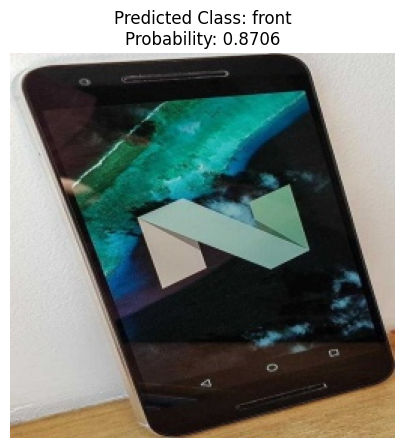

Image: testing_sample/0P2VC24O4MBV.jpg
Predicted class: front (index: 2)
Probability: 0.8706


In [105]:
image_path = "testing_sample/0P2VC24O4MBV.jpg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES, 
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

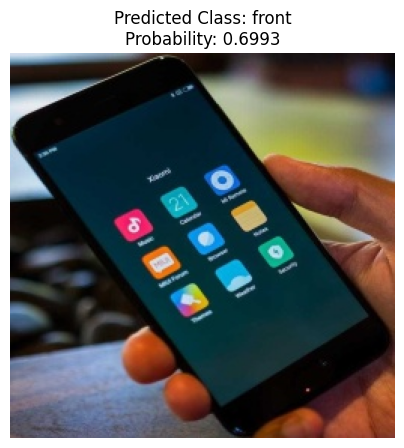

Image: testing_sample/1OELKXBLGQ0Y.jpg
Predicted class: front (index: 2)
Probability: 0.6993


In [106]:
image_path = "testing_sample/1OELKXBLGQ0Y.jpg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

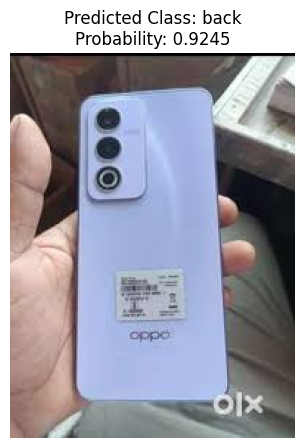

Image: testing_sample/oppo.jpeg
Predicted class: back (index: 1)
Probability: 0.9245


In [114]:
image_path = "testing_sample/oppo.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

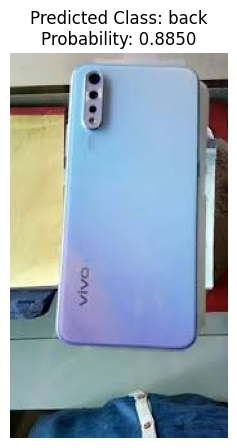

Image: testing_sample/vivo_1.jpeg
Predicted class: back (index: 1)
Probability: 0.8850


In [118]:
image_path = "testing_sample/vivo_1.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

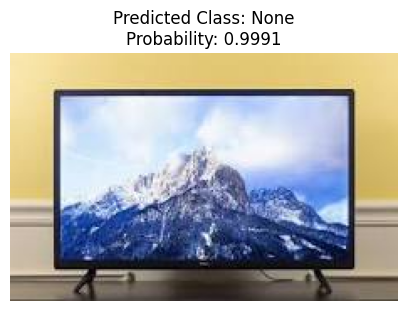

Image: testing_sample/tv.jpeg
Predicted class: None (index: 0)
Probability: 0.9991


In [119]:
image_path = "testing_sample/tv.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

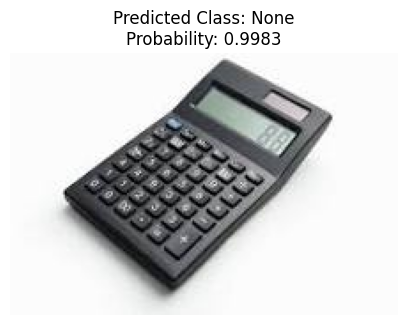

Image: testing_sample/cal.jpeg
Predicted class: None (index: 0)
Probability: 0.9983


In [122]:
image_path = "testing_sample/cal.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=model,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

# Testing Mobilenetv2


In [104]:
mode_1 = MobileNetV2Custom(num_classes=config.NUM_CLASSES)
mode_1, checkpoint = load_best_model(mode_1, 'mobilenet_model/mobilenetv2_custom_run_1/models/best_model.pth', device=config.DEVICE)

Loaded epoch 3, Val Loss: 0.0544, Val Acc: 93.33%


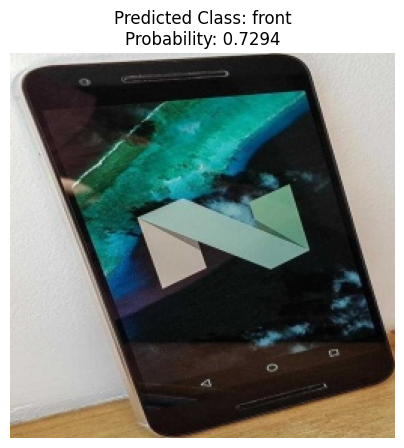

Image: testing_sample/0P2VC24O4MBV.jpg
Predicted class: front (index: 2)
Probability: 0.7294


In [107]:
image_path = "testing_sample/0P2VC24O4MBV.jpg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES, 
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

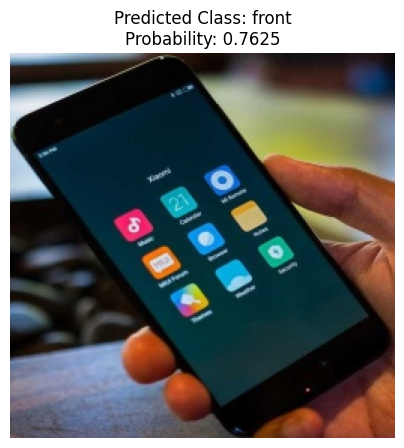

Image: testing_sample/1OELKXBLGQ0Y.jpg
Predicted class: front (index: 2)
Probability: 0.7625


In [109]:
image_path = "testing_sample/1OELKXBLGQ0Y.jpg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

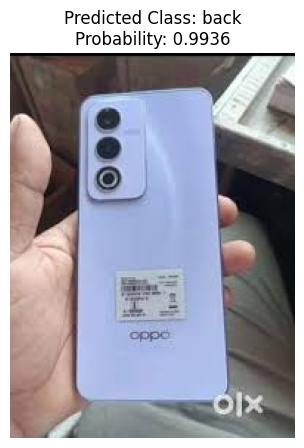

Image: testing_sample/oppo.jpeg
Predicted class: back (index: 1)
Probability: 0.9936


In [115]:
image_path = "testing_sample/oppo.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

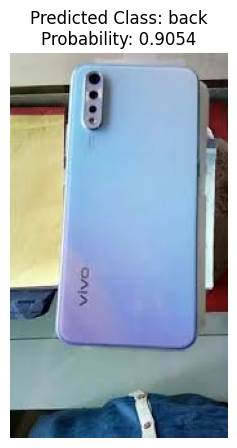

Image: testing_sample/vivo_1.jpeg
Predicted class: back (index: 1)
Probability: 0.9054


In [117]:
image_path = "testing_sample/vivo_1.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

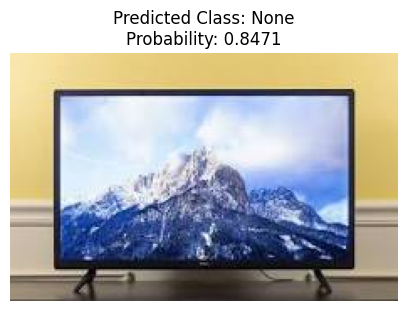

Image: testing_sample/tv.jpeg
Predicted class: None (index: 0)
Probability: 0.8471


In [120]:
image_path = "testing_sample/tv.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)

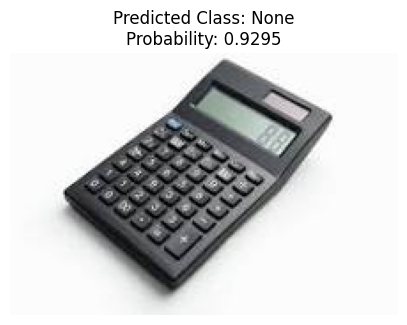

Image: testing_sample/cal.jpeg
Predicted class: None (index: 0)
Probability: 0.9295


In [123]:
image_path = "testing_sample/cal.jpeg"
pred_class, pred_prob, pred_index = predict_single_image(
    image_path=image_path,
    model=mode_1,
    class_names=config.CLASSES,
    transform=val_transforms,  # <- same as used for validation
    device=config.DEVICE
)